# Instrumental variables

## Baby example on mock dataset

### Constructing the dataset

Create four random series of length $N=1000$

- $x$: education
- $y$: salary
- $z$: ambition
- $q$: early smoking 

such that:

1. $x$ and $z$ cause $y$
2. $z$ causes $x$
3. $q$ is correlated with $x$, not with $z$


A problem arises when the confounding factor $z$ is not observed. In that case, we can estimate the direct effect of $x$ on $y$ by using $q$ as an instrument.

Run the follwing code to create a mock dataset.

In [6]:
import numpy as np
import pandas as pd

In [7]:
N = 100000
ϵ_z = np.random.randn(N)*0.1
ϵ_x = np.random.randn(N)*0.1
ϵ_q = np.random.randn(N)*0.01
ϵ_y = np.random.randn(N)*0.01

In [8]:
z = 0.1 + ϵ_z
x = 0.1 + z + ϵ_x
q = 0.5 + 0.1234*ϵ_x + ϵ_q
y  = 1.0 + 0.9*x + 0.4*z + ϵ_y

In [9]:
df = pandas.DataFrame({
    "x": x,
    "y": y,
    "z": z,
    "q": q
})

__Describe the dataframe. Compute the correlations between the variables. Are they compatible with the hypotheses for IV?__

Here are the results from the database:

In [10]:
df.describe()

,x,y,z,q
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.199828,1.219851,0.100136,0.499938
std,0.140688,0.157459,0.099429,0.015817
min,-0.428323,0.564264,-0.337928,0.427705
25%,0.105090,1.114408,0.033333,0.489319
50%,0.199758,1.219557,0.100052,0.499948
75%,0.293940,1.324484,0.166898,0.510562
max,0.793323,1.914595,0.559487,0.574688


In [11]:
df.corr()

,x,y,z,q
x,1.000000,0.981771,0.704518,0.551077
y,0.981771,1.000000,0.818857,0.443053
z,0.704518,0.818857,1.000000,0.000038
q,0.551077,0.443053,0.000038,1.000000


We observe:
- cor(q, x) non zero: the instrument is relevant
    - close to zero: might be a weak instrument (we would need to check significance)
- cor(q, z) = 0 : the instrument is really exogenous

### OLS Regression

Use `linearmodels` to  run a regression estimating the effect of $x$ on $y$ (note the slight API change w.r.t. `statsmodels`). Comment.

What is the problem with this regression? How can it be detected?



In [12]:
from linearmodels import OLS

model = OLS.from_formula("y ~ x", df)
res = model.fit()
res.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:                      y   R-squared:                      0.9639
Estimator:                        OLS   Adj. R-squared:                 0.9639
No. Observations:              100000   F-statistic:                 2.655e+06
Date:                Tue, Feb 13 2024   P-value (F-stat)                0.0000
Time:                        22:54:26   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      1.0003     0.0002     6087.5     0.0000      1.0000      1.0006
x              1.0988     0.0007     1629.3     0.0000      1.0975      1.1001
==============================================================================
"""

Regression is globally significant (p-value for Fisher test < 0.00001).
The coefficient $\beta=1.0999$ in front of $x$ is also very significant at a 0.001% level but does not match the model (`y  = 1.0 + 0.9*x + 0.4*z + ϵ_y`)

### Regress again $y$ on $x$, this time controling for missing variable $z$.



In [15]:
from linearmodels import IV2SLS
formula = (
    "y ~ x + z"
)
mod = IV2SLS.from_formula(formula, df)
res = mod.fit()
res

OLS Estimation Summary                            
==============================================================================
Dep. Variable:                      y   R-squared:                      0.9960
Estimator:                        OLS   Adj. R-squared:                 0.9960
No. Observations:              100000   F-statistic:                 2.472e+07
Date:                Tue, Feb 13 2024   P-value (F-stat)                0.0000
Time:                        22:54:54   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      1.0000  5.477e-05  1.826e+04     0.0000      0.9999      1.0001
x              0.8997     0.0003     2842.6     0.0000      0.8991      0.9003
z              0.3999     0.0004     893.62     0.0000      0.3990      0.4008
==============================================================================
OLSResults, id: 0x7f38288327b0

Now we see that the coefficient in front of `x` is the correct one (that is 0.9).

### Instrumental variable

Now we try to run a regression without knowing the value of `z`.

Make a causality graph, summarizing what you know from the equations.




Use $q$ to instrument the effect of x on y. Comment.

In [17]:
from linearmodels.iv import IV2SLS

formula = "y ~ 1 + [x ~ q]"
model = IV2SLS.from_formula(formula, df)
result = model.fit()
result

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                      y   R-squared:                      0.9323
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9323
No. Observations:              100000   F-statistic:                 2.898e+05
Date:                Tue, Feb 13 2024   P-value (F-stat)                0.0000
Time:                        22:55:41   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      1.0400     0.0004     2903.5     0.0000      1.0393      1.0407
x              0.8998     0.0017     538.37     0.0000      0.8965      0.9031
==============================================================================

Endogenous: x
Instruments: q
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x7f3828838cb0

We observe that the result is, again, the correct one. This is especially impressive since *we didn't have access to the confounding factor `z`* and couldn't add it to the regression. Instead, we had another source of randomness `q` that we used to instrument the regression.

## Return on Education

We follow the excellent R [tutorial](https://www.econometrics-with-r.org/12-6-exercises-10.html) from the (excellent) *Econometrics with R* book.

The goal is to measure the effect of schooling on earnings, while correcting the endogeneity bias by using distance to college as an instrument.

__Download the college distance using `get_dataset` function and make a nice dataframe. Describe the dataset. Plot a histogram of distance (you can use `matplotlib`'s `hist` function or `seaborn`).__

https://vincentarelbundock.github.io/Rdatasets/datasets.html

In [18]:
import statsmodels.api as sm
ds = sm.datasets.get_rdataset("CollegeDistance", "AER")

In [21]:
df = ds.data

In [22]:
df.head()

,gender,ethnicity,score,fcollege,mcollege,home,urban,unemp,wage,distance,tuition,education,income,region
rownames,,,,,,,,,,,,,,
1,male,other,39.150002,yes,no,yes,yes,6.2,8.09,0.2,0.88915,12,high,other
2,female,other,48.869999,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
3,male,other,48.740002,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
4,male,afam,40.400002,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
5,female,other,40.480000,no,no,no,yes,5.6,8.09,0.4,0.88915,13,low,other


In [23]:
df.describe()

,score,unemp,wage,distance,tuition,education
count,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000
mean,50.889029,7.597215,9.500506,1.802870,0.814608,13.807765
std,8.701910,2.763581,1.343067,2.297128,0.339504,1.789107
min,28.950001,1.400000,6.590000,0.000000,0.257510,12.000000
25%,43.924999,5.900000,8.850000,0.400000,0.484990,12.000000
50%,51.189999,7.100000,9.680000,1.000000,0.824480,13.000000
75%,57.769999,8.900000,10.150000,2.500000,1.127020,16.000000
max,72.809998,24.900000,12.960000,20.000000,1.404160,18.000000


__How is `education` encoded? Create a binary variable `education_binary` to replace it.__

In [24]:
df['income'].unique()
# education variable takes string values ("high" or "low"). 

array(['high', 'low'], dtype=object)

In [25]:
# we need to convert them into 1 and 0 first
df['income_binary'] = (df['income'] == "high")*1

In [26]:
# other option 1
df['incomeb'] = df['income'].map({'high' : 1, 'low': 0})

In [27]:
# other option 2
df['incomeb'] = (df['income'] == 'high')*1

__Plot an histogram of distance to college.__

(array([3241.,  831.,  399.,  156.,   45.,   17.,   10.,   19.,   17.,
           4.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

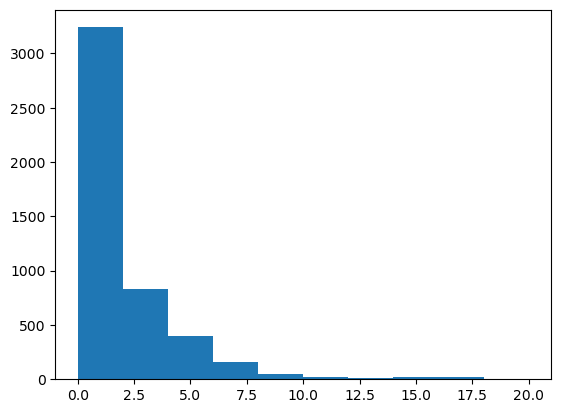

In [28]:
from matplotlib import pyplot as plt
plt.hist(df['distance'])

<Axes: xlabel='distance', ylabel='Count'>

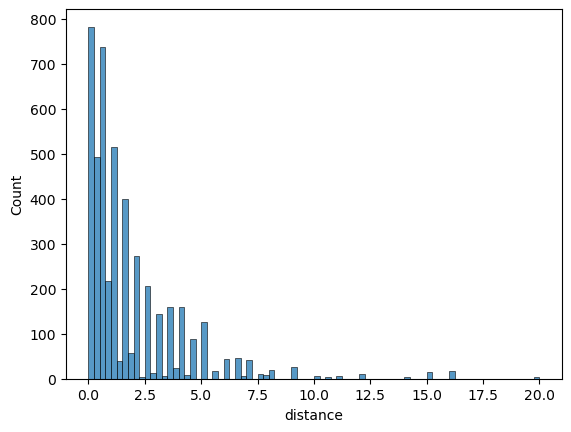

In [32]:
# same with seaborn
import seaborn as sns
sns.histplot(df['distance'])

__Run the naive regression $\text{incomeb}=\beta_0 + \beta_1 \text{education} + u$ using linearmodels. Comment.__



In [33]:
from linearmodels.iv import IV2SLS # we can use IV2SLS instead of OLS to run regular regressions

formula = "incomeb ~ education"
model = IV2SLS.from_formula(formula, df)
result = model.fit()
result

OLS Estimation Summary                            
==============================================================================
Dep. Variable:                incomeb   R-squared:                      0.0480
Estimator:                        OLS   Adj. R-squared:                 0.0478
No. Observations:                4739   F-statistic:                    227.43
Date:                Tue, Feb 13 2024   P-value (F-stat)                0.0000
Time:                        22:56:43   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -0.4780     0.0499    -9.5702     0.0000     -0.5759     -0.3801
education      0.0555     0.0037     15.081     0.0000      0.0483      0.0627
==============================================================================
OLSResults, id: 0x7f3819703590

We find that education explains higher income with a significant, but low coefficient 0.05.


__Augment the regression with `unemp`, `hispanic`, `af-am`, `female` and `urban`. Notice that categorical variables are encoded automatically. What are the treatment values? Change it using the syntax (`C(var,Treatment='ref')`)__

In [34]:
from linearmodels.iv import IV2SLS

formula = "incomeb ~ education + unemp + gender + ethnicity"
model = IV2SLS.from_formula(formula, df)
result = model.fit()
result

OLS Estimation Summary                            
==============================================================================
Dep. Variable:                incomeb   R-squared:                      0.0811
Estimator:                        OLS   Adj. R-squared:                 0.0802
No. Observations:                4739   F-statistic:                    443.38
Date:                Tue, Feb 13 2024   P-value (F-stat)                0.0000
Time:                        22:56:44   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
                                   Parameter Estimates                                   
=========================================================================================
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------
Intercept                -0.4361     0.0533    -8.1797     0.0000     -0.5406     -0.3316
education                 0.0511     0.0037     13.982     0.0000      0.0439      0.0582
unemp                    -0.0111     0.0022    -4.9609     0.0000     -0.0155     -0.0067
gender[T.male]            0.0484     0.0128     3.7866     0.0002      0.0234      0.0735
ethnicity[T.hispanic]    -0.0249     0.0185    -1.3425     0.1794     -0.0612      0.0114
ethnicity[T.other]        0.1347     0.0163     8.2871     0.0000      0.1029      0.1666
=========================================================================================
OLSResults, id: 0x7f38195de570

In [35]:
df['ethnicity'].unique()

array(['other', 'afam', 'hispanic'], dtype=object)

In the regression above, some variables have been created for each value of the categorical vairables (save for the reference value which doesn't appear).
In the case of variable `ethnicity`, we see that  `hispanic` and `other` are two of the three values taken by variable `ethnicity`. This means that value `afam` was taken as reference.

We can change the reference variable as follows:

In [36]:
# needed only if you use the function Treatment in the formulas
from linearmodels.iv import IV2SLS

formula = "incomeb ~ education + unemp + C(gender) + C(ethnicity,Treatment(reference='other'))"
model = IV2SLS.from_formula(formula, df)
result = model.fit()
result

OLS Estimation Summary                            
==============================================================================
Dep. Variable:                incomeb   R-squared:                      0.0811
Estimator:                        OLS   Adj. R-squared:                 0.0802
No. Observations:                4739   F-statistic:                    443.38
Date:                Tue, Feb 13 2024   P-value (F-stat)                0.0000
Time:                        22:56:45   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
                                                   Parameter Estimates                                                    
==========================================================================================================================
                                                        Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 -0.3014     0.0540    -5.5788     0.0000     -0.4073     -0.1955
education                                                  0.0511     0.0037     13.982     0.0000      0.0439      0.0582
unemp                                                     -0.0111     0.0022    -4.9609     0.0000     -0.0155     -0.0067
C(gender)[T.male]                                          0.0484     0.0128     3.7866     0.0002      0.0234      0.0735
C(ethnicity, Treatment(reference='other'))[T.afam]        -0.1347     0.0163    -8.2871     0.0000     -0.1666     -0.1029
C(ethnicity, Treatment(reference='other'))[T.hispanic]    -0.1596     0.0149    -10.710     0.0000     -0.1888     -0.1304
==========================================================================================================================
OLSResults, id: 0x7f3819605d90

__Comment the results and explain the endogeneity problem__

Adding additional regressors has increased the fit (adj. R^2 from 0.04 to 0.08) without changing the coefficient on the education level. This would imply that regression is robust.

However, we might have an endogeneity issue with some potential other factors explaining both income level and salary (cf many discussions in the course).

__Explain why distance to college might be used to instrument the effect of schooling.__

Assuming that the decision to live in 
a given county does not depend on the presence of a college nearby, the distance to college should be exogenous.

The distance to college is probably correlated with the decision to go so the instrument should have some power (opposite of weak)


__Run an IV regression, where `distance` is used to instrument schooling.__

look at: 
    https://bashtage.github.io/linearmodels/
   (two-stage least squares)

In [37]:
from linearmodels.iv import IV2SLS
 
formula = "incomeb ~ [education ~ distance] + unemp + C(gender) + C(ethnicity, Treatment(reference='other'))"
model = IV2SLS.from_formula(formula, df)
result = model.fit()
result

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                incomeb   R-squared:                     -0.1339
Estimator:                    IV-2SLS   Adj. R-squared:                -0.1351
No. Observations:                4739   F-statistic:                    1748.5
Date:                Tue, Feb 13 2024   P-value (F-stat)                0.0000
Time:                        22:56:48   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                                                   Parameter Estimates                                                    
==========================================================================================================================
                                                        Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------------------------------------
unemp                                                     -0.0100     0.0025    -3.9704     0.0001     -0.0149     -0.0051
C(gender)[T.female]                                       -1.9566     0.5039    -3.8830     0.0001     -2.9441     -0.9690
C(gender)[T.male]                                         -1.9109     0.5042    -3.7897     0.0002     -2.8991     -0.9226
C(ethnicity, Treatment(reference='other'))[T.afam]        -0.0753     0.0259    -2.9005     0.0037     -0.1261     -0.0244
C(ethnicity, Treatment(reference='other'))[T.hispanic]    -0.1247     0.0203    -6.1432     0.0000     -0.1645     -0.0849
education                                                  0.1692     0.0358     4.7261     0.0000      0.0990      0.2393
==========================================================================================================================

Endogenous: education
Instruments: distance
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x7f38194d20c0

__Comment the results. Compare with the R tutorials.__

The estimate we get for the return on education is three times higher and highly significant.